In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
df = pd.read_csv('./data/quejas-clientes.csv', usecols=lambda column: column not in ['Unnamed: 0', 'Complaint ID'])

print("Distribución de clases en df['Product'] antes de asignar y:")
print(df['Product'].value_counts())
X = df.drop(columns=['Product'])
y = df['Product']
print("Distribución de clases en y:")
print(y.value_counts())

# Dividir evitando sesgos de clase con stratify, y con semilla para reproducibilidad
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Distribución de clases en df['Product'] antes de asignar y:
Product
Debt collection            7494
Mortgage                   6612
Credit reporting           5717
Credit card                2830
Bank account or service    2609
Consumer loan              1314
Student loan                785
Payday loan                 348
Money transfers             232
Prepaid card                175
Other financial service      40
Name: count, dtype: int64
Distribución de clases en y:
Product
Debt collection            7494
Mortgage                   6612
Credit reporting           5717
Credit card                2830
Bank account or service    2609
Consumer loan              1314
Student loan                785
Payday loan                 348
Money transfers             232
Prepaid card                175
Other financial service      40
Name: count, dtype: int64


RandomForest accuracy en test: 0.994
HistGradientBoosting accuracy en test: 0.999

Reporte de clasificación para RandomForest:

                         precision    recall  f1-score   support

Bank account or service     0.9905    0.9962    0.9933       522
          Consumer loan     0.9809    0.9772    0.9790       263
            Credit card     0.9860    0.9965    0.9912       566
       Credit reporting     1.0000    1.0000    1.0000      1143
        Debt collection     1.0000    1.0000    1.0000      1499
        Money transfers     0.9574    0.9783    0.9677        46
               Mortgage     0.9947    0.9970    0.9958      1323
Other financial service     1.0000    0.1250    0.2222         8
            Payday loan     0.9688    0.8857    0.9254        70
           Prepaid card     0.9688    0.8857    0.9254        35
           Student loan     0.9752    1.0000    0.9874       157

               accuracy                         0.9940      5632
              macro avg  

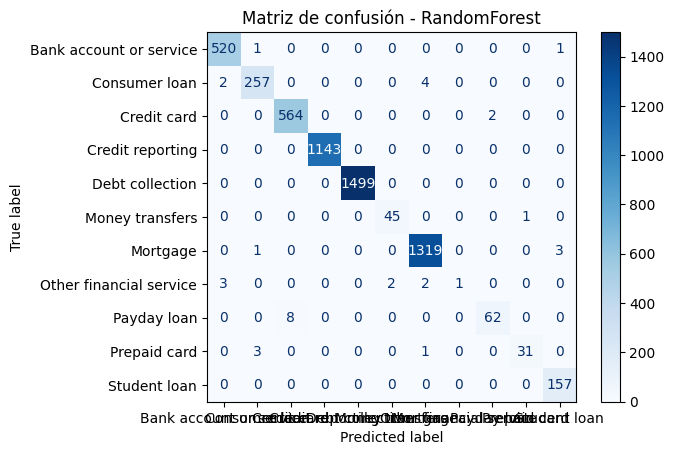


Reporte de clasificación para HistGradientBoosting:

                         precision    recall  f1-score   support

Bank account or service     1.0000    0.9981    0.9990       522
          Consumer loan     0.9962    1.0000    0.9981       263
            Credit card     0.9982    1.0000    0.9991       566
       Credit reporting     1.0000    1.0000    1.0000      1143
        Debt collection     1.0000    1.0000    1.0000      1499
        Money transfers     0.9787    1.0000    0.9892        46
               Mortgage     0.9992    1.0000    0.9996      1323
Other financial service     0.8571    0.7500    0.8000         8
            Payday loan     1.0000    0.9857    0.9928        70
           Prepaid card     1.0000    0.9714    0.9855        35
           Student loan     1.0000    1.0000    1.0000       157

               accuracy                         0.9991      5632
              macro avg     0.9845    0.9732    0.9785      5632
           weighted avg     0.9991

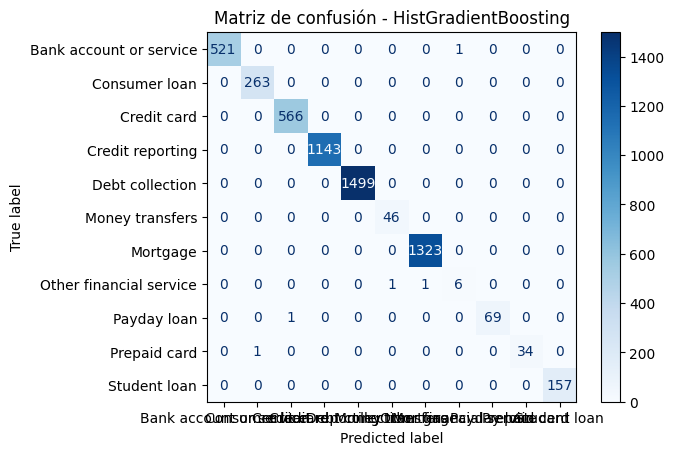

Top 10 features por importancia:
                 feature  importance
1            Sub-product    0.310253
0               ZIP code    0.276410
2                  Issue    0.274567
6   Date sent to company    0.088384
10    Consumer disputed?    0.010821
7                Company    0.010406
5          Date received    0.008968
4                  State    0.008441
3              Sub-issue    0.007599
8       Company response    0.003310

Features seleccionadas (importance > 0.01):
['Sub-product', 'ZIP code', 'Issue', 'Date sent to company', 'Consumer disputed?', 'Company']
RandomForest con features filtradas precisión test: 0.991


In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Identificar columnas categóricas y numéricas para preprocesar distinto
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['number']).columns.tolist()

# Definir preprocesadores para cada tipo con manejo robusto
cat_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
num_transformer = RobustScaler()

preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, categorical_cols),
    ('num', num_transformer, numerical_cols)
])

# Modelos a evaluar
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42)
}

# Crear pipelines combinando preprocesador y modelo
pipelines = {
    name: Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ]) for name, model in models.items()
}

# Entrenar y reportar precisión en test
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)
    print(f'{name} accuracy en test: {score:.3f}')

# Reportes detallados y matriz de confusión para diagnóstico
for name, pipe in pipelines.items():
    y_pred = pipe.predict(X_test)
    print(f"\nReporte de clasificación para {name}:\n")
    print(classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.named_steps['classifier'].classes_)
    disp.plot(cmap='Blues')
    plt.title(f'Matriz de confusión - {name}')
    plt.show()

# Selección de variables relevantes con base en importancia del modelo Random Forest
rf = pipelines['RandomForest'].named_steps['classifier']
features = numerical_cols + categorical_cols
importances = rf.feature_importances_

feat_imp = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("Top 10 features por importancia:")
print(feat_imp.head(10))

# Filtrar variables sobre umbral para simplificar modelo
threshold = 0.01
selected_features = feat_imp[feat_imp['importance'] > threshold]['feature'].tolist()

print(f"\nFeatures seleccionadas (importance > {threshold}):")
print(selected_features)

# Preprocesador reducido para features seleccionadas
preprocessor_filtered = ColumnTransformer(transformers=[
    ('cat', cat_transformer, [c for c in selected_features if c in categorical_cols]),
    ('num', num_transformer, [c for c in selected_features if c in numerical_cols])
])

# Pipeline reducido con Random Forest para solo variables relevantes
pipe_filtered = Pipeline(steps=[
    ('preprocessor', preprocessor_filtered),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipe_filtered.fit(X_train[selected_features], y_train)
score_filtered = pipe_filtered.score(X_test[selected_features], y_test)
print(f'RandomForest con features filtradas precisión test: {score_filtered:.3f}')


In [3]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Predicciones con pipeline reducido
y_pred = pipe_filtered.predict(X_test[selected_features])

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score macro:", f1_score(y_test, y_pred, average='macro'))
print("Precision macro:", precision_score(y_test, y_pred, average='macro'))
print("Recall macro:", recall_score(y_test, y_pred, average='macro'))
print("\nReporte detallado:\n", classification_report(y_test, y_pred))


Accuracy: 0.9907670454545454
F1-score macro: 0.9026789437695402
Precision macro: 0.9823265109541853
Recall macro: 0.886449078006131

Reporte detallado:
                          precision    recall  f1-score   support

Bank account or service       0.99      1.00      1.00       522
          Consumer loan       0.99      0.99      0.99       263
            Credit card       0.96      0.99      0.98       566
       Credit reporting       1.00      1.00      1.00      1143
        Debt collection       0.99      0.99      0.99      1499
        Money transfers       0.96      0.93      0.95        46
               Mortgage       1.00      1.00      1.00      1323
Other financial service       1.00      0.12      0.22         8
            Payday loan       0.98      0.81      0.89        70
           Prepaid card       0.94      0.91      0.93        35
           Student loan       0.99      0.99      0.99       157

               accuracy                           0.99      5632


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import LearningRateScheduler
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar backend de Matplotlib (para Jupyter Notebook)
%matplotlib inline
# Para scripts de Python sin interfaz gráfica, descomentar:
# import matplotlib
# matplotlib.use('Agg')

# -------------------------------
# 1. Definir scheduler personalizado para el learning rate
# -------------------------------
def custom_lr_schedule(epoch, lr):
    initial_lr = 1e-4  # Learning rate inicial bajo
    max_lr = 1e-2      # Learning rate máximo
    ramp_up_epochs = 10  # Épocas para alcanzar el máximo
    decay_epochs = 40    # Épocas para decaer después del máximo
    total_epochs = 50    # Épocas totales (ajusta según tu configuración)

    if epoch < ramp_up_epochs:
        # Aumento lineal hasta max_lr
        lr = initial_lr + (max_lr - initial_lr) * (epoch / ramp_up_epochs)
    else:
        # Decaimiento exponencial después del máximo
        decay_factor = np.exp(-0.1 * (epoch - ramp_up_epochs))
        lr = max_lr * decay_factor
    
    return lr

# Crear callback para el scheduler
lr_scheduler = LearningRateScheduler(custom_lr_schedule)

# -------------------------------
# 2. Cargar y explorar datos
# -------------------------------
# Asumiendo que df ya está cargado como DataFrame
# Ejemplo: df = pd.read_csv('dataset.csv')

# Verificar distribución de clases en Product
print("Distribución de clases en 'Product':")
print(df['Product'].value_counts())

# Verificar valores nulos en Product
print("Valores nulos en Product:", df['Product'].isnull().sum())

# -------------------------------
# 3. Definir variables predictoras y target
# -------------------------------
# Features seleccionadas (todas categóricas)
selected_features = ['Issue', 'Sub-product', 'Sub-issue', 'Company', 'Company response', 'State']
X = df[selected_features]
y = df['Product']

# Verificar distribución en y
print("Distribución de clases en y:")
print(y.value_counts())

# Verificar valores nulos en X
print("Valores nulos en X por columna:")
print(X.isnull().sum())

# Codificar la variable objetivo
label_enc = LabelEncoder()
y_enc = label_enc.fit_transform(y)
print("Clases codificadas:", label_enc.classes_)

# Calcular pesos de clase para manejar el desbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_enc), y=y_enc)
class_weight_dict = dict(zip(np.unique(y_enc), class_weights))
print("Pesos de clase:", class_weight_dict)

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# Verificar distribución en y_train y y_test
print("Distribución en y_train:")
print(pd.Series(label_enc.inverse_transform(y_train)).value_counts())
print("Distribución en y_test:")
print(pd.Series(label_enc.inverse_transform(y_test)).value_counts())

# Verificar datos de entrada
print("Tamaño de X_train:", X_train.shape)
print("Tamaño de y_train:", y_train.shape)

# -------------------------------
# 4. Preprocesador con KNNImputer
# -------------------------------
# Todas las columnas son categóricas
categorical_cols = selected_features
numerical_cols = []

# Preprocesador para categóricas: codificar primero, luego imputar con KNN
cat_transformer = Pipeline([
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('imputer', KNNImputer(n_neighbors=5, weights='uniform'))
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, categorical_cols)
], remainder='drop')

# Verificar datos después del preprocesamiento
X_train_transformed = preprocessor.fit_transform(X_train)
print("Valores nulos en X_train después de preprocesamiento:")
print(pd.DataFrame(X_train_transformed, columns=categorical_cols).isnull().sum())

# -------------------------------
# 5. Definir modelo
# -------------------------------
def create_model(n_features, n_classes):
    model = Sequential()
    model.add(Input(shape=(n_features,)))
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    
    if n_classes == 2:
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    else:
        model.add(Dense(n_classes, activation='softmax'))
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

keras_clf = KerasClassifier(
    model=create_model,
    model__n_features=len(categorical_cols),
    model__n_classes=len(label_enc.classes_),
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    class_weight=class_weight_dict,
    callbacks=[lr_scheduler]  # Añadir el scheduler de learning rate
)

# -------------------------------
# 6. Pipeline completo
# -------------------------------
pipe_nn = Pipeline([
    ('preprocessor', preprocessor),
    ('nn_classifier', keras_clf)
])

# Entrenar modelo
history = pipe_nn.fit(X_train, y_train)


# -------------------------------
# 7. Evaluación
# -------------------------------
y_pred_enc = pipe_nn.predict(X_test)
y_pred = label_enc.inverse_transform(y_pred_enc)
y_test_orig = label_enc.inverse_transform(y_test)

# Métricas
print("Accuracy:", accuracy_score(y_test_orig, y_pred))
print("F1-score macro:", f1_score(y_test_orig, y_pred, average='macro'))
print("F1-score weighted:", f1_score(y_test_orig, y_pred, average='weighted'))
print("Precision macro:", precision_score(y_test_orig, y_pred, average='macro'))
print("Recall macro:", recall_score(y_test_orig, y_pred, average='macro'))
print("\nReporte detallado:\n", classification_report(y_test_orig, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test_orig, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_enc.classes_, yticklabels=label_enc.classes_)
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()


Distribución de clases en 'Product':
Product
Debt collection            7494
Mortgage                   6612
Credit reporting           5717
Credit card                2830
Bank account or service    2609
Consumer loan              1314
Student loan                785
Payday loan                 348
Money transfers             232
Prepaid card                175
Other financial service      40
Name: count, dtype: int64
Valores nulos en Product: 0
Distribución de clases en y:
Product
Debt collection            7494
Mortgage                   6612
Credit reporting           5717
Credit card                2830
Bank account or service    2609
Consumer loan              1314
Student loan                785
Payday loan                 348
Money transfers             232
Prepaid card                175
Other financial service      40
Name: count, dtype: int64
Valores nulos en X por columna:
Issue                   2
Sub-product         10574
Sub-issue           14945
Company                 

ValueError: Found input variables with inconsistent numbers of samples: [22524, 65945]